In [1]:
import os
import csv
import cv2
import numpy as np

#Loading CSV File
lines = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

In [2]:
from sklearn.model_selection import train_test_split
import sklearn

train_samples, validation_samples = train_test_split(lines, test_size=0.2)
correction = 0.2
def generator(samples, batch_size=16):
    num_samples = len(samples)
    correction = 0.2
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for batch_sample in batch_samples:
                for i in range(3):
                    name = './data/IMG/'+batch_sample[i].split('/')[-1]
                    image = cv2.imread(name)
                    measurement = float(batch_sample[3])
                    if i == 1:
                        measurement = measurement + correction
                    elif i == 2:
                        measurement = measurement - correction
                    images.append(image)
                    measurements.append(measurement)

            #Data Augmentation
            #Flipping the images
            #Multiplying the steering angle measurement with -1
            augmented_images, augmented_measurements = [], []
            for image, measurement in zip(images, measurements):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)

            #Converting the list into numpy arrays
            #This constitutes Features and Labels
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)

            yield sklearn.utils.shuffle(X_train, y_train)

In [3]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=16)
validation_generator = generator(validation_samples, batch_size=16)

#Model Architecture starts from here
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

model = Sequential()

#Preprocessing the images
#Normalization and Mean Centre
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))

#Image cropping
model.add(Cropping2D(cropping=((70,25),(0,0))))

#Nvidia Model starts here
model.add(Convolution2D(24,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2), activation="relu"))
model.add(Convolution2D(64,3,3,subsample=(2,2), activation="relu"))

model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=2, verbose=1)
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*2*3, validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=2)

model.save('model.h52')

Using TensorFlow backend.


Epoch 1/2
38568/38568 [==============================] - 337s - loss: 0.0188 - val_loss: 0.0180
Epoch 2/2
38568/38568 [==============================] - 330s - loss: 0.0160 - val_loss: 0.0141


dict_keys(['loss', 'val_loss'])


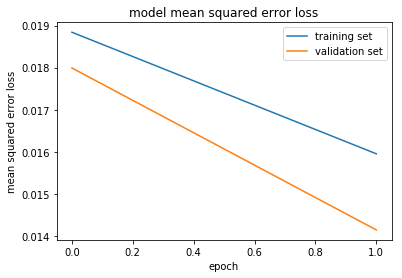

In [4]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()